<h1> Cuda verification </h1>

In [1]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


<h1>Augmentation pipeline </h1>

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.SquareSymmetry(p=0.5),
    A.RandomCrop(height=180, width=180,  p=1.0),
    A.Resize(height=224, width=224),
    A.RandomRain(slant_range=(-15,15), drop_length=15, drop_width=1, rain_type="default", blur_value=7 ,p=0.3),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.3),
    A.Rotate(limit=45, p=0.4),
    A.GaussNoise(std_range=(0.1, 0.2), per_channel=True  ,p=0.5),
    A.ColorJitter(brightness=(0.8, 1.1), contrast=(0.8, 1.1), saturation=(0.8, 1.1), hue=(-0.5, 0.5)),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.25), fill=0, p=0.5),
        A.GridDropout(ratio=0.5, random_offset=True,  p=0.5)
    ]),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

<h2>Data preparation</h2>

In [3]:
import random
import shutil
from tqdm import tqdm
from pathlib import Path

def prepare_image_datasets(source_dir, base_dir, split_ratios=(0.7, 0.2, 0.1)):

     if not (0.999 < sum(split_ratios) < 1.001):
             raise ValueError('split_ratios must sum to 1')

     source_path = Path(source_dir)
     base_path = Path(base_dir)

     if not source_path.is_dir():
         print(f'Source directory {source_path.name} does not exist')
         return

     train_path = base_path / 'train'
     test_path = base_path / 'test'
     val_path = base_path / 'val'

     class_names = [d.name for d in source_path.iterdir() if d.is_dir()]

     if not class_names:
         print(f'Source directory {source_path.name} does not contain any class names')
         return

     for directory in [train_path, test_path, val_path]:
         for class_name in class_names:
             (directory / class_name).mkdir(parents=True, exist_ok=True)

     for class_name in class_names:

         class_source_path = source_path / class_name

         files = [f for f in class_source_path.iterdir() if f.is_file()]

         random.shuffle(files)

         total_files = len(files)
         train_end = int(total_files * split_ratios[0])
         test_end = train_end + int(total_files * split_ratios[1])

         split_data = {
             'train': (files[:train_end], train_path),
             'test': (files[train_end:test_end], test_path),
             'val': (files[test_end:], val_path)
         }

         print(f"Copying {class_name} to {base_path}")

         for split_name, (file_list, destination_path) in split_data.items():

             dest_class_path = destination_path / class_name

             for file_path in tqdm(file_list, desc=f'Copying {split_name} files'):

                 shutil.copy2(file_path, dest_class_path / file_path.name)

         print(f'Copying {class_name} finished!')

     print("Data splitting successful!")


In [4]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

# data = CustomDataset(root='dataset', transform=training_pipeline)

# image, path = data[0]
#
# print(path)
#
# image = image.permute(1,2,0).numpy()
#
# image = (image * np
#          .array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
# image = np.clip(image, 0, 1)
# image = (image * 255).astype(np.uint8)
#
# plt.imshow(image)
# plt.show()

<h2> Data splitting </h2>

In [ ]:
source_data_dir = r'C:\Users\LANCE\OneDrive\Desktop\rice_pest\Finalized_datasets'
base_data_dir = r'C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets'

if not source_data_dir or not base_data_dir:
    raise ValueError('Source and base data directory not found')

prepare_image_datasets(source_data_dir, base_data_dir, split_ratios=(0.7, 0.2, 0.1))


<h2> Training functions and hyperparameters</h2>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class LSoftmax(nn.Module):

    def __init__(self, input_features, number_of_classes, m=4):
        super(LSoftmax, self).__init__()
        self.input_features = input_features
        self.number_of_classes = number_of_classes
        self.m = m

        if m <= 1:
            raise ValueError('m must be greater than 1')

        # Initialization of weights through xavier uniform.
        self.weight = nn.Parameter(torch.FloatTensor(number_of_classes,  input_features))
        nn.init.xavier_uniform_(self.weight)

    # Forward propagation
    def forward(self, x, labels=None):

        # normalization of weights and input vector features.
        normalize_weight = F.normalize(self.weight, p=2, dim=1)
        normalize_x = F.normalize(x, p=2, dim=1)

        # Cosine similarity: perform DOT product multiplication between weights and input vectors.
        # cos_theta = F.linear(normalize_x, normalize_weight.t())

        cos_theta = F.linear(normalize_x, normalize_weight)

        if labels is None:
            return cos_theta

        cos_theta = cos_theta.clamp(-1,1)

        # Convert cosine similarity into actual angles.
        theta = torch.acos(cos_theta)

        # Gathered the correct classes as one vector and reshape it in to a 2d with one column.
        target_theta = theta.gather(1, labels.view(-1,1))

        # applies the margin to the correct classes
        m_theta = self.m * target_theta
        k = (m_theta / math.pi).floor()

        # Compute the angular margin to get a new hard target score for prediction
        psi_theta = ((-1)**k) * torch.cos(m_theta) - (2*k)

        # Scattered the new values got from psi_theta to its corresponding classes
        final_logits = cos_theta.scatter(1, labels.view(-1,1), psi_theta)

        return final_logits


In [ ]:
# t = torch.tensor([[1, 2, 3, 4],
#                   [5,6,7,8]])
#
# t.gather(1, torch.tensor())

t = torch.tensor([[1, 2, 3, 4],
                  [5,6,7,8]])

print(t.view(-1,2))

In [ ]:
tensor_float_shaped = torch.FloatTensor(2, 3)
nn.init.xavier_uniform_(tensor_float_shaped)
print(tensor_float_shaped)

<h3> LSmax Test </h3>

In [ ]:
# NUM_FEATURES = 1280
# NUM_CLASSES = 6
# BATCH_SIZE = 4
# MARGIN = 4
#
# lsoftmax_layer = LSoftmax(
#     input_features=NUM_FEATURES,
#     number_of_classes=NUM_CLASSES,
#     m=MARGIN
# )
#
# dummy_features = torch.randn(BATCH_SIZE, NUM_FEATURES)
# dummy_labels = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,))
# res = lsoftmax_layer(dummy_features, dummy_labels)
#
# print("Shape of the output logits:", res.shape)
# print("\nOutput Logits Tensor (first 2 rows):")
# print(res.detach().numpy()[:2])

In [6]:
import torchvision.models as models

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes, margin):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: Instantiate LSoftmax as new customized final layer.
        self.base_model.classifier[1] = LSoftmax(
            input_features=num_filters,
            number_of_classes=num_classes,
            m=margin
        )

    # Forward propagation
    def forward(self, x, labels=None):

        # Passed the features in feature extraction layer.
        features = self.base_model.features(x)

        # Adaptive average pooling: returns a 2d scaled vector features.
        features = F.adaptive_avg_pool2d(features, (1,1)).reshape(features.shape[0], -1)

        # Implementation of the LSoftmax through passing the feature vectors for classification.
        logits = self.base_model.classifier[1](features, labels)

        # return the result logits
        return logits

    def unfreeze_last_block(self):
        print("\nUnfreezing the last convolutional block for fine-tuning...")

        for param in self.base_model.features[-1].parameters():
            param.requires_grad = True

    def unfreeze_before_last_block(self):
        print("\nUnfreezing the before last convolutional block for fine-tuning...")

        for param in self.base_model.features[-2].parameters():
            param.requires_grad = True


In [7]:
def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device):
    train_losses = []
    test_losses = []
    accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epoch):
        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data, labels)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        # --- TESTING PHASE ---
        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                output_loss = model(inputs, labels)
                loss = criterion(output_loss, labels)
                running_test_loss += loss.item()

                output_predictions = model(inputs, labels=None)
                _, predicted = torch.max(output_predictions.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.3f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'MobileNetV2_rice_pest_classificationV2.pth')

    tqdm.write('Training done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

<h3> Data loader </h3>

In [8]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

classes = train_set.classes

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_training_result(train_losses, test_losses):

    if len(train_losses) != len(test_losses):
        print("Error: train_losses and test_losses must have the same length.")
        return

    epochs = range(1, len(train_losses) + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': train_losses,
        'Testing Loss': test_losses,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(accuracy):
    x = np.array(range(1, len(accuracy) + 1))
    y = np.array(accuracy)

    plt.figure(figsize=(10, 6))  # Set figure size first
    plt.plot(x, y, label='Accuracy')
    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(hist1, hist2):

    data_dict = {
        'epoch': len(hist1['train_loss'] + hist2['train_loss']),
        'train_loss': hist1['train_loss'] + hist2['train_loss'],
        'test_loss': hist1['test_loss'] + hist2['test_loss'],
        'accuracy': hist1['accuracy'] + hist2['accuracy'],
    }

    history_df = pd.DataFrame(data_dict)

    history_df.to_csv('training_history.csv', index=False)

    print("Data saved!")


Phase 1


Test epoch: 1: 100%|██████████| 34/34 [00:07<00:00,  4.77it/s]


Epoch 1/30 | Train Loss: 4.5565 | Test Loss: 4.5151 | Accuracy: 57.69% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 2/30 | Train Loss: 4.5201 | Test Loss: 4.4876 | Accuracy: 65.76% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 3/30 | Train Loss: 4.5075 | Test Loss: 4.4709 | Accuracy: 68.15% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 4/30 | Train Loss: 4.5021 | Test Loss: 4.4532 | Accuracy: 65.15% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 5/30 | Train Loss: 4.3790 | Test Loss: 4.2015 | Accuracy: 25.70% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 6/30 | Train Loss: 4.0538 | Test Loss: 3.8099 | Accuracy: 46.39% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 7/30 | Train Loss: 3.7478 | Test Loss: 3.5947 | Accuracy: 62.24% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 8/30 | Train Loss: 3.5807 | Test Loss: 3.6149 | Accuracy: 64.40% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.12it/s]


Epoch 9/30 | Train Loss: 3.5780 | Test Loss: 3.5981 | Accuracy: 62.15% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 10/30 | Train Loss: 3.5776 | Test Loss: 3.5931 | Accuracy: 61.21% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 11/30 | Train Loss: 3.5773 | Test Loss: 3.6039 | Accuracy: 61.96% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 12: 100%|██████████| 34/34 [00:06<00:00,  5.40it/s]


Epoch 12/30 | Train Loss: 3.5764 | Test Loss: 3.5931 | Accuracy: 62.10% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


Epoch 13/30 | Train Loss: 3.5784 | Test Loss: 3.6031 | Accuracy: 63.51% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 14/30 | Train Loss: 3.5801 | Test Loss: 3.5978 | Accuracy: 62.48% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.46it/s]


Epoch 15/30 | Train Loss: 3.5760 | Test Loss: 3.5960 | Accuracy: 61.73% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 16/30 | Train Loss: 3.5820 | Test Loss: 3.6048 | Accuracy: 63.32% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 17/30 | Train Loss: 3.5774 | Test Loss: 3.6030 | Accuracy: 61.16% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 18/30 | Train Loss: 3.5776 | Test Loss: 3.5957 | Accuracy: 60.83% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.05it/s]


Epoch 19/30 | Train Loss: 3.5795 | Test Loss: 3.6067 | Accuracy: 59.85% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 20/30 | Train Loss: 3.5786 | Test Loss: 3.5939 | Accuracy: 63.27% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 21/30 | Train Loss: 3.5783 | Test Loss: 3.6032 | Accuracy: 61.68% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 22: 100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


Epoch 22/30 | Train Loss: 3.5758 | Test Loss: 3.5989 | Accuracy: 61.54% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 23/30 | Train Loss: 3.5788 | Test Loss: 3.5958 | Accuracy: 62.85% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]


Epoch 24/30 | Train Loss: 3.5779 | Test Loss: 3.6038 | Accuracy: 61.73% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  4.93it/s]


Epoch 25/30 | Train Loss: 3.5772 | Test Loss: 3.6077 | Accuracy: 61.82% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 26/30 | Train Loss: 3.5771 | Test Loss: 3.6045 | Accuracy: 60.51% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 27/30 | Train Loss: 3.5817 | Test Loss: 3.5999 | Accuracy: 62.62% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 28: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 28/30 | Train Loss: 3.5789 | Test Loss: 3.6044 | Accuracy: 62.57% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 29: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 29/30 | Train Loss: 3.5802 | Test Loss: 3.6016 | Accuracy: 61.63% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 30/30 | Train Loss: 3.5771 | Test Loss: 3.5943 | Accuracy: 63.18% | GPU Memory (Alloc/Reserved): 0.06/1.824 GB
Training done!
Phase 2

Unfreezing the last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 1/20 | Train Loss: 3.5762 | Test Loss: 3.5903 | Accuracy: 62.95% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 2/20 | Train Loss: 3.5715 | Test Loss: 3.5895 | Accuracy: 63.41% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 3/20 | Train Loss: 3.5691 | Test Loss: 3.5778 | Accuracy: 63.04% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 4/20 | Train Loss: 3.5606 | Test Loss: 3.5764 | Accuracy: 63.18% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 5: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 5/20 | Train Loss: 3.5561 | Test Loss: 3.5766 | Accuracy: 63.32% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 6: 100%|██████████| 34/34 [00:06<00:00,  5.03it/s]


Epoch 6/20 | Train Loss: 3.5546 | Test Loss: 3.5773 | Accuracy: 63.65% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 7: 100%|██████████| 34/34 [00:06<00:00,  5.42it/s]


Epoch 7/20 | Train Loss: 3.5511 | Test Loss: 3.5678 | Accuracy: 63.65% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.39it/s]


Epoch 8/20 | Train Loss: 3.5474 | Test Loss: 3.5622 | Accuracy: 63.56% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]


Epoch 9/20 | Train Loss: 3.5463 | Test Loss: 3.5610 | Accuracy: 63.46% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 10/20 | Train Loss: 3.5366 | Test Loss: 3.5578 | Accuracy: 63.79% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 11: 100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


Epoch 11/20 | Train Loss: 3.5347 | Test Loss: 3.5465 | Accuracy: 63.88% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 12: 100%|██████████| 34/34 [00:11<00:00,  2.97it/s]


Epoch 12/20 | Train Loss: 3.5322 | Test Loss: 3.5429 | Accuracy: 64.02% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.65it/s]


Epoch 13/20 | Train Loss: 3.5275 | Test Loss: 3.5448 | Accuracy: 64.07% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 14/20 | Train Loss: 3.5261 | Test Loss: 3.5344 | Accuracy: 64.02% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 15/20 | Train Loss: 3.5211 | Test Loss: 3.5334 | Accuracy: 63.84% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 16/20 | Train Loss: 3.5184 | Test Loss: 3.5373 | Accuracy: 64.02% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 17/20 | Train Loss: 3.5153 | Test Loss: 3.5248 | Accuracy: 64.31% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 18/20 | Train Loss: 3.5128 | Test Loss: 3.5174 | Accuracy: 64.45% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 19/20 | Train Loss: 3.5120 | Test Loss: 3.5185 | Accuracy: 64.31% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB


Test epoch: 20: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 20/20 | Train Loss: 3.5067 | Test Loss: 3.5151 | Accuracy: 64.49% | GPU Memory (Alloc/Reserved): 0.07/1.826 GB
Training done!


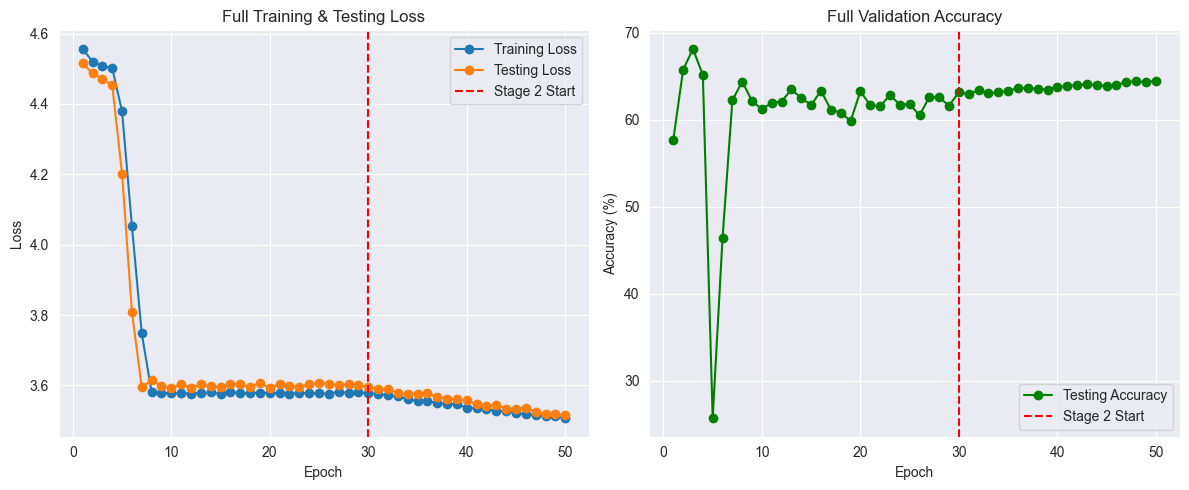

Data saved!


In [10]:
import torch.optim as optim

hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = 6
weight_decay = 1e-2
num_margin = 4

model = PestClassifierMobileNetV2(num_classes=classes, margin=num_margin).to(hardware)
criterion = nn.CrossEntropyLoss()

# Phase 1
print('Phase 1')

optimizer_p1 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=weight_decay)

result_1, accuracy_p1 = train_and_test(model=model, optimizer=optimizer_p1, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=30, device=hardware)

# Phase 2
print('Phase 2')
model.unfreeze_last_block()

optimizer_p2 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=weight_decay)

result_2, accuracy_p2 = train_and_test(model=model, optimizer=optimizer_p2, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=20, device=hardware)

# Phase 3
print('Phase 3')

full_train_loss = result_1['train_loss'] + result_2['train_loss']
full_test_loss = result_1['test_loss'] + result_2['test_loss']
full_accuracy = result_1['accuracy'] + result_2['accuracy']
total_epochs = len(full_train_loss)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs + 1), full_train_loss, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs + 1), full_test_loss, marker='o', label='Testing Loss')
plt.axvline(x=len(result_1['train_loss']), color='r', linestyle='--', label='Stage 2 Start')
plt.title('Full Training & Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs + 1), full_accuracy, marker='o', color='g', label='Testing Accuracy')
plt.axvline(x=len(result_1['accuracy']), color='r', linestyle='--', label='Stage 2 Start')
plt.title('Full Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

save_historical_data(result_1, result_2)

In [1]:
import torch

# Check and report VRAM usage
# torch.cuda.memory_allocated() gives the current tensor memory usage in bytes.
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")
#
# torch.cuda.empty_cache()
#
# allocated_after_clear = torch.cuda.memory_allocated('cuda') / (1024 * 1024)
# print(f"Memory Allocated after clearing: {allocated_after_clear:.2f} MB")



--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [ ]:
def softmax_thresholding():



In [12]:
from PIL import Image
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():

        result = model(image_tensor, labels=None)

        probability = F.softmax(result, dim=1)

        confidence, predicted = torch.max(probability, 1)

        predicted_class = classes[predicted.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score


In [90]:
import torchvision.models as models

classes_names = train_set.classes

model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names), margin=4)
model_inference.load_state_dict(torch.load('MobileNetV2_rice_pest_classificationV2.pth', map_location=hardware))
image_path = 'datasets/val/whorl-maggot/WHORL-MAGGOTS_original_whorl--2--jpg_08e3ab6e-dea1-41ce-a1cb-54f9b46b246b_jpg.rf.d80a90912b6cc9aed7f8b1ef588c8348.jpg'

pest, confidence_score = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")

The predicted pest is: stem-borer
Confidence: 20.22%


In [ ]:
print(model.features[0])

In [94]:
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

# print(model.classifier[1])
print(model.features[-1])
print("qweqwe")
print(model.features[-2])
print("asdasd")

print(model.parameters)

Conv2dNormActivation(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
qweqwe
InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
      (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Conv2d(960, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
asdasd
<bound method Module.parameters of MobileNetV2(
  (features): Seque